In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cite for EMNIST dataset:

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

In [13]:
#importing the required packages
from tensorflow.keras.utils import get_file
import numpy as np
import gzip
import shutil
import os
import scipy.io
import zipfile

In [14]:
#extracting the files and stuff

zip_path = '/content/drive/MyDrive/matlab.zip'  # update if different
extract_path = '/content/emnist'  # temporary extraction folder in Colab

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

mat_path = extract_path + '/matlab/emnist-balanced.mat'
mat = scipy.io.loadmat(mat_path)


In [15]:
#preprocessing data

x_train = mat['dataset']['train'][0][0]['images'][0][0]
y_train = mat['dataset']['train'][0][0]['labels'][0][0]
x_test = mat['dataset']['test'][0][0]['images'][0][0]
y_test = mat['dataset']['test'][0][0]['labels'][0][0]

# Normalize pixel values
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Reshape to 28x28 images
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,807 (897.68 KB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#training the data

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 138s 39ms/step - accuracy: 0.6937 - loss: 1.0447 - val_accuracy: 0.8431 - val_loss: 0.4663
Epoch 2/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 138s 39ms/step - accuracy: 0.8579 - loss: 0.4086 - val_accuracy: 0.8580 - val_loss: 0.4150
Epoch 3/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 135s 37ms/step - accuracy: 0.8779 - loss: 0.3382 - val_accuracy: 0.8697 - val_loss: 0.3759
Epoch 4/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 140s 40ms/step - accuracy: 0.8905 - loss: 0.2929 - val_accuracy: 0.8715 - val_loss: 0.3696
Epoch 5/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 132s 37ms/step - accuracy: 0.8985 - loss: 0.2643 - val_accuracy: 0.8741 - val_loss: 0.3749


In [29]:
#saving the model

model.save('/content/drive/MyDrive/emnist_cnn.keras')


In [30]:
from tensorflow.keras.models import load_model
model = load_model('emnist_cnn.keras')

def predict_character(img):
    img = img.reshape(1, 28, 28, 1)  # ensure correct shape
    prediction = model.predict(img)
    return np.argmax(prediction)


In [69]:
import numpy as np
from PIL import Image, ImageDraw
def stroke_to_image_with_pressure(strokes, canvas_size=128, image_size=28,
                                  min_width=1, max_width=8, background=255):
    """
    Convert strokes with pressure data to an image compatible with EMNIST models

    Args:
        strokes: List of strokes, where each stroke is a list of (x,y,pressure) points
        canvas_size: Size of initial canvas (larger for better precision)
        image_size: Final size of image (28x28 for EMNIST)
        min_width: Minimum stroke width
        max_width: Maximum stroke width
        background: Background color (255 for white)

    Returns:
        Tuple of (processed array for model, PIL Image for visualization)
    """
    # Create blank white canvas
    img = Image.new("L", (canvas_size, canvas_size), color=background)
    draw = ImageDraw.Draw(img)

    # For single list of points (not grouped as strokes)
    if not isinstance(strokes[0][0], (list, tuple)):
        strokes = [strokes]

    # Draw each stroke
    for stroke in strokes:
        for i in range(len(stroke) - 1):
            x1, y1, p1 = stroke[i]
            x2, y2, p2 = stroke[i + 1]

            # Scale coordinates to canvas size
            x1 = canvas_size * x1 / 100
            y1 = canvas_size * y1 / 100
            x2 = canvas_size * x2 / 100
            y2 = canvas_size * y2 / 100

            # Calculate line width based on pressure
            avg_pressure = (p1 + p2) / 2
            width = int(min_width + (max_width - min_width) * avg_pressure)

            # Draw the line
            draw.line([(x1, y1), (x2, y2)], fill=0, width=width)

    # Center the content (find bounding box of drawn content)
    bbox = img.getbbox()
    if bbox:
        # If content exists (bbox is not None)
        left, top, right, bottom = bbox
        width, height = right - left, bottom - top

        # Create a new image with padding to center the content
        new_img = Image.new("L", (canvas_size, canvas_size), color=background)

        # Calculate position to center the content
        paste_x = (canvas_size - width) // 2
        paste_y = (canvas_size - height) // 2

        # Crop and paste to center
        cropped = img.crop(bbox)
        new_img.paste(cropped, (paste_x, paste_y))
        img = new_img

    # Resize to EMNIST dimensions

    # Convert to numpy array and normalize
    img_array = np.array(img.resize((image_size, image_size), Image.LANCZOS))
    img_array = 255 - img_array  # Invert (EMNIST has white digits on black)
    img_array = img_array / 255.0  # Normalize to [0,1]

    # Reshape for CNN input
    img_array = img_array.reshape(1, image_size, image_size, 1)

    return img_array, img.resize((image_size, image_size), Image.LANCZOS)


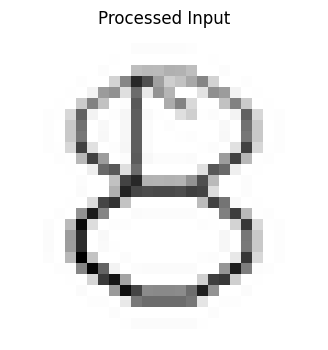

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted character: a (Class: 36,Confidence: 0.2450)

Top 3 predictions:
  a: 0.2450
  D: 0.2256
  O: 0.1016


In [77]:
# handwriting_predictor.py
import sys
sys.path.append('/content/drive/MyDrive')
from tensorflow.keras.models import load_model
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# === Sample Stroke Data ===
sample_strokes = [[
    (30, 15, 0.2), (25, 10, 0.3), (20, 15, 0.4), (20, 20, 0.5), (25, 25, 0.6),
    (30, 25, 0.6), (35, 20, 0.5), (35, 15, 0.4), (30, 10, 0.3), (25, 10, 0.2),
    (25, 25, 0.7), (20, 30, 0.8), (20, 35, 0.9), (25, 40, 0.8), (30, 40, 0.7),
    (35, 35, 0.6), (35, 30, 0.5), (30, 25, 0.4)
]]

# === Improved stroke-to-image function ===
def stroke_to_image_with_pressure(strokes, canvas_size=128, image_size=28,
                                 min_width=1, max_width=6, background=255):
    """
    Convert strokes with pressure data to an image compatible with EMNIST
    """
    img = Image.new("L", (canvas_size, canvas_size), color=background)
    draw = ImageDraw.Draw(img)

    # For single list of points (not grouped as strokes)
    if not isinstance(strokes[0][0], (list, tuple)):
        strokes = [strokes]

    # Get all points to find the bounding box
    all_points = []
    for stroke in strokes:
        for point in stroke:
            all_points.append((point[0], point[1]))

    # Find bounding box of all points
    if all_points:
        min_x = min(p[0] for p in all_points)
        max_x = max(p[0] for p in all_points)
        min_y = min(p[1] for p in all_points)
        max_y = max(p[1] for p in all_points)

        # Add padding
        width = max_x - min_x
        height = max_y - min_y
        padding = max(width, height) * 0.2  # 20% padding

        min_x -= padding
        max_x += padding
        min_y -= padding
        max_y += padding
    else:
        # Default if no points
        min_x, max_x = 0, 100
        min_y, max_y = 0, 100

    # Draw each stroke with adjusted coordinates
    for stroke in strokes:
        for i in range(len(stroke) - 1):
            x1, y1, p1 = stroke[i]
            x2, y2, p2 = stroke[i + 1]

            # Scale to canvas
            x1_scaled = (x1 - min_x) / (max_x - min_x) * canvas_size
            y1_scaled = (y1 - min_y) / (max_y - min_y) * canvas_size
            x2_scaled = (x2 - min_x) / (max_x - min_x) * canvas_size
            y2_scaled = (y2 - min_y) / (max_y - min_y) * canvas_size

            # Calculate line width based on pressure
            avg_pressure = (p1 + p2) / 2
            width = int(min_width + (max_width - min_width) * avg_pressure)

            # Draw the line
            draw.line([(x1_scaled, y1_scaled), (x2_scaled, y2_scaled)], fill=0, width=width)

    # Resize to EMNIST dimensions
    small_img = img.resize((image_size, image_size), Image.LANCZOS)

    # Convert to numpy array and normalize
    img_array = np.array(small_img)
    img_array = 255 - img_array  # Invert (EMNIST has white digits on black)
    img_array = img_array / 255.0  # Normalize to [0,1]

    # Reshape for CNN input
    img_array = img_array.reshape(1, image_size, image_size, 1)

    return img_array, small_img

# === Convert Strokes to Image ===
img_array, img = stroke_to_image_with_pressure(sample_strokes)

# === Display Image ===
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray')
plt.title("Processed Input")
plt.axis('off')
plt.show()

# === Load Model ===
model = load_model('/content/drive/MyDrive/emnist_cnn.keras')

# === Predict with confidence ===
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction[0])
confidence = prediction[0][predicted_class]

# === Direct mapping for EMNIST balanced ===
# This is more reliable than using the mapping matrix
balanced_chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
if predicted_class < len(balanced_chars):
    char = balanced_chars[predicted_class]
else:
    # Fallback to the matrix mapping
    emnist = scipy.io.loadmat('/content/emnist/matlab/emnist-balanced.mat')
    mapping = emnist['dataset']['mapping'][0][0]
    unicode_val = mapping[predicted_class][0]
    char = chr(unicode_val)

print(f"Predicted character: {char} (Class: {predicted_class},Confidence: {confidence:.4f})")

# === Show top 3 predictions ===
top_3_indices = np.argsort(prediction[0])[-3:][::-1]
print("\nTop 3 predictions:")
for idx in top_3_indices:
    conf = prediction[0][idx]
    if idx < len(balanced_chars):
        c = balanced_chars[idx]
    else:
        unicode_val = mapping[idx][0]
        c = chr(unicode_val)
    print(f"  {c}: {conf:.4f}")
